<a href="https://colab.research.google.com/github/jayanthk17/ACN_LAB/blob/main/gnn-resunet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
#import scienceplots
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow.keras.callbacks
#from keras import backend as K
import tensorflow.keras.backend as K

from keras.regularizers import l2

from albumentations import (
    Compose, HorizontalFlip, Rotate, GridDistortion,
    ElasticTransform, RandomBrightnessContrast, HueSaturationValue
)

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
transforms = Compose([
        ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        GridDistortion(p=0.5)])

<ipython-input-2-95be94b5b599>:2: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),


In [ ]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(9, 9))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap = 'bone')
    plt.show()

In [ ]:
def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = x.astype(np.int32)
    return x

In [ ]:
def load_data(x_path, y_path):
    images = os.listdir(x_path)
    masks = os.listdir(y_path)

    train_x = [os.path.join(x_path, image) for image in images]
#     train_y = [os.path.join(y_path, mask) for mask in masks]

    train_y = list(map(lambda x : x.replace('.jpg', '.tiff'), train_x))
    train_y = list(map(lambda x : x.replace('/content/drive/MyDrive/Datasets/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan',
                                            '/content/drive/MyDrive/Datasets/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks'), train_y))


    train_x, valid_x = train_test_split(train_x, test_size=0.15, random_state=0)
    train_y, valid_y = train_test_split(train_y, test_size=0.15, random_state=0)

    return (train_x, train_y), (valid_x, valid_y)


In [ ]:
def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.shuffle(buffer_size= 5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset

def preprocess(x,y):

    def aug_fn(image, mask):
        img_data = {"image":image}
        mask_data = {"mask":mask}
        img_data = transforms(**image)
        mask_data = transforms(**mask)
        aug_img = img_data["image"]
        aug_mask = mask_data["mask"]
        return aug_img, aug_mask

    def f(x,y):
        x = x.decode()
        y = y.decode()

        image = read_image(x)
        mask = read_mask(y)
        augmented = transforms(image=image,mask=mask)
        aug_img=augmented['image']
        aug_mask = augmented['mask']

        return aug_img, aug_mask

    image, mask = tf.numpy_function(f, [x,y], [tf.float32, tf.int32])
    #image, mask = tf.numpy_function(aug_fn,[image, mask],[tf.float32, tf.int32])
    mask = tf.one_hot(mask, 3, dtype = tf.int32)
    image.set_shape([512,512,3])
    mask.set_shape([512,512,3])

    return image, mask

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

def multi_unet_model(n_classes=3, IMG_HEIGHT=512, IMG_WIDTH=512, IMG_CHANNELS=3):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)
    s = inputs

    #Encoder path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Decoder path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

#def dice_coef_3Class(y_true, y_pred, numLabels=3):
 #   dice=0
 #   for index in range(numLabels):
 #       dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
 #   return dice/numLabels


import tensorflow.keras.backend as K

def dice_coef_3Class(y_true, y_pred, smooth=1):
    y_true = K.cast(y_true, 'float32')  # ✅ ensure same type as y_pred
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


In [ ]:
class LossHistory(tensorflow.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Image Path: /content/drive/MyDrive/Datasets/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan/volume-3_slice_365.jpg
Mask Path: /content/drive/MyDrive/Datasets/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks/volume-3_slice_365.tiff
Image exists: True
Mask exists: True


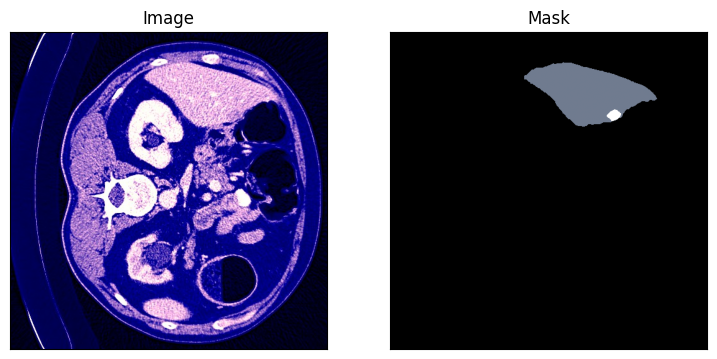

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 512,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256, 256,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_7[0][0]  

 Total params: 1,941,139 (7.40 MB)

 Trainable params: 1,941,139 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 512, 512, 3))
  warnings.warn(msg)


1526/1526 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.9102 - dice_coef_3_class: 0.8751 - loss: 0.2159 - one_hot_mean_io_u: 0.4656 
Epoch 1: val_loss improved from inf to 0.13042, saving model to Multiclass-Semantic_one_hot_encoder_catcross_U-Net.h5


1526/1526 ━━━━━━━━━━━━━━━━━━━━ 22980s 15s/step - accuracy: 0.9102 - dice_coef_3_class: 0.8752 - loss: 0.2159 - one_hot_mean_io_u: 0.4656 - val_accuracy: 0.9528 - val_dice_coef_3_class: 0.9330 - val_loss: 0.1304 - val_one_hot_mean_io_u: 0.5292 - learning_rate: 1.0000e-04
Epoch 2/50
 679/1526 ━━━━━━━━━━━━━━━━━━━━ 3:15:18 14s/step - accuracy: 0.9747 - dice_coef_3_class: 0.9630 - loss: 0.0703 - one_hot_mean_io_u: 0.5860

In [ ]:
if __name__ == "__main__":
    np.random.seed(42)
    tf.random.set_seed(42)
    i = random.randint(0, 6100)

    #train_frame_path = 'C:/Users/jayan/.kaggle/input/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan'
    #train_mask_path = 'C:/Users/jayan/.kaggle/input/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks'
    train_frame_path = '/content/drive/MyDrive/Datasets/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan'
    train_mask_path = '/content/drive/MyDrive/Datasets/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks'

    (train_x, train_y), (valid_x, valid_y) = load_data(train_frame_path, train_mask_path)
    print("Image Path:", train_x[i])
    print("Mask Path:", train_y[i])

    print("Image exists:", os.path.exists(train_x[i]))
    print("Mask exists:", os.path.exists(train_y[i]))
    visualize(image = read_image(train_x[i]), mask = read_mask(train_y[i]))

    IMG_HEIGHT = 512
    IMG_WIDTH = 512
    IMG_CHANNELS = 3
    n_classes = 3
    lr = 1e-4
    batch_size = 4
    epochs = 50

    model = multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(lr),
                  metrics=['accuracy', dice_coef_3Class, tf.keras.metrics.OneHotMeanIoU(num_classes=3)])

    model.summary()

    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

    train_steps = len(train_x) // batch_size
    valid_steps = len(valid_x) // batch_size

    history_class = LossHistory()

    callbacks = [
        ModelCheckpoint("Multiclass-Semantic_one_hot_encoder_catcross_U-Net.h5", verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6),
        history_class
    ]

    history = model.fit(
        train_dataset,
        steps_per_epoch=train_steps,
        validation_data=valid_dataset,
        validation_steps=valid_steps,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    model.save('50epochsmodel.h5')


In [ ]:
import os
import cv2
import glob
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Custom imports assumed
# from model import multi_unet_model
# from utils import load_data, read_image, read_mask, tf_dataset, visualize, dice_coef_3Class, LossHistory

# Set seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Paths
train_frame_path = '/content/drive/MyDrive/Datasets/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan'
train_mask_path  = '/content/drive/MyDrive/Datasets/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks'

# Get lists of image and mask files
image_files = [f for f in os.listdir(train_frame_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
mask_files  = [f for f in os.listdir(train_mask_path) if f.lower().endswith(('.tiff', '.png'))]

print("Number of image files:", len(image_files))
print("Number of mask files :", len(mask_files))

# --- Load dataset ---
def load_data(frame_path, mask_path, test_size=0.2):
    image_files = sorted(glob.glob(os.path.join(frame_path, "*.jpg")))
    mask_files  = sorted(glob.glob(os.path.join(mask_path, "*.tiff")))

    # Check for mismatches between number of images and masks
    assert len(image_files) == len(mask_files), f"Mismatch: {len(image_files)} images vs {len(mask_files)} masks"
    assert len(image_files) > 0, "No image files found!"
    assert len(mask_files) > 0, "No mask files found!"

    # Optional: Check filename matching
    for img, mask in zip(image_files, mask_files):
        img_base = os.path.splitext(os.path.basename(img))[0]
        mask_base = os.path.splitext(os.path.basename(mask))[0]
        assert img_base == mask_base, f"Mismatch: {img} vs {mask}"

    # Split data into train and validation sets
    return train_test_split(image_files, mask_files, test_size=test_size, random_state=42)

(train_x, train_y), (valid_x, valid_y) = load_data(train_frame_path, train_mask_path)

# Visualize one example
i = random.randint(0, len(train_x) - 1)
print(f"\nImage Path: {train_x[i]}")
print(f"Mask Path : {train_y[i]}")
print("Image exists:", os.path.exists(train_x[i]))
print("Mask exists :", os.path.exists(train_y[i]))

# Assuming visualize and read_image/read_mask are defined
visualize(image=read_image(train_x[i]), mask=read_mask(train_y[i]))

# --- Model config ---
IMG_HEIGHT = 512
IMG_WIDTH = 512
IMG_CHANNELS = 3
n_classes = 3
lr = 1e-4
batch_size = 4
epochs = 50

# --- Model creation ---
model = multi_unet_model(
    n_classes=n_classes,
    IMG_HEIGHT=IMG_HEIGHT,
    IMG_WIDTH=IMG_WIDTH,
    IMG_CHANNELS=IMG_CHANNELS
)

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    metrics=['accuracy', dice_coef_3Class, tf.keras.metrics.OneHotMeanIoU(num_classes=n_classes)]
)

model.summary()

# --- Data pipeline ---
# Make sure tf_dataset properly loads batches of data
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

train_steps = len(train_x) // batch_size
valid_steps = len(valid_x) // batch_size

# --- Callbacks ---
callbacks = [
    ModelCheckpoint("Multiclass-Semantic_one_hot_encoder_catcross_U-Net.h5", verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6),
    LossHistory()
]

# --- Training ---
history = model.fit(
    train_dataset,
    steps_per_epoch=train_steps,
    validation_data=valid_dataset,
    validation_steps=valid_steps,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

# Save final model
model.save('Final_model_Multiclass-Semantic_one_hot_encoder_catcross_U-NET.h5')


In [ ]:
import os

# Paths
train_frame_path = '/content/drive/MyDrive/Datasets/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan'
train_mask_path  = '/content/drive/MyDrive/Datasets/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks'

# Get lists of image and mask files
image_files = [f for f in os.listdir(train_frame_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
mask_files  = [f for f in os.listdir(train_mask_path) if f.lower().endswith(('.tiff', '.png'))]

# Extract base filenames without extensions
image_bases = [os.path.splitext(f)[0] for f in image_files]
mask_bases  = [os.path.splitext(f)[0] for f in mask_files]

# Find unmatched files (images or masks without corresponding pairs)
unmatched_images = [f for f in image_files if os.path.splitext(f)[0] not in mask_bases]
unmatched_masks  = [f for f in mask_files if os.path.splitext(f)[0] not in image_bases]

# Remove unmatched image files
for img in unmatched_images:
    os.remove(os.path.join(train_frame_path, img))
    print(f"Removed image: {img}")

# Remove unmatched mask files
for mask in unmatched_masks:
    os.remove(os.path.join(train_mask_path, mask))
    print(f"Removed mask: {mask}")


In [ ]:
hist_df = pd.DataFrame(history.history)

hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

print(history.history.keys())


In [ ]:
def plot_segm_history_dice(history, metrics=["dice_coef_3_class", "val_dice_coef_3_class"]):
    plt.figure(figsize=(12, 6))
    for metric in metrics:
        if metric in history.history:
            plt.plot(history.history[metric], linewidth=3, label=metric)
        else:
            print(f"Warning: '{metric}' not found in history.")
    plt.ylabel("Dice Coefficient 3 Class", fontsize=20)
    plt.xlabel("Epoch", fontsize=20)
    plt.legend(loc="center right", fontsize=15)
    plt.grid(True)
    plt.show()

# Call it
plot_segm_history_dice(history)


In [ ]:
def plot_segm_history_one_hot(history, metrics=["one_hot_mean_io_u_5", "val_one_hot_mean_io_u_5"]):
    plt.figure(figsize=(12, 6))
    for metric in metrics:
        if metric in history.history:
            plt.plot(history.history[metric], linewidth=3, label=metric)
        else:
            print(f"Warning: '{metric}' not found in history.")
    plt.ylabel("One Hot Mean IOU", fontsize=20)
    plt.xlabel("Epoch", fontsize=20)
    plt.legend(loc="center right", fontsize=15)
    plt.grid(True)
    plt.show()

# Call it
plot_segm_history_one_hot(history)


In [ ]:
def plot_segm_history_one_hot(history, metrics=["one_hot_mean_io_u_5", "val_one_hot_mean_io_u_5"]):
    plt.figure(figsize=(12, 6))
    for metric in metrics:
        if metric in history.history:
            plt.plot(history.history[metric], linewidth=3, label=metric)
        else:
            print(f"Warning: '{metric}' not found in history.")
    plt.ylabel("One Hot Mean IOU", fontsize=20)
    plt.xlabel("Epoch", fontsize=20)
    plt.legend(fontsize=15)
    plt.grid(True)
    plt.show()

# Call it
plot_segm_history_one_hot(history)


In [ ]:
def plot_segm_history(history,
                      metrics=["accuracy", "val_accuracy", "dice_coef_3_class", "val_dice_coef_3_class",
                               "one_hot_mean_io_u_5", "val_one_hot_mean_io_u_5"],
                      losses=["loss", "val_loss"]):
    # Plotting metrics over epochs
    plt.figure(figsize=(12, 6))
    for metric in metrics:
        plt.plot(history.history[metric], linewidth=3)
    plt.suptitle("metrics over epochs", fontsize=20)
    plt.ylabel("metric", fontsize=20)
    plt.xlabel("epoch", fontsize=20)
    plt.legend(metrics, loc="center right", fontsize=15)
    plt.show()

    # Plotting losses over epochs
    plt.figure(figsize=(12, 6))
    for loss in losses:
        plt.plot(history.history[loss], linewidth=3)
    plt.suptitle("loss over epochs", fontsize=20)
    plt.ylabel("loss", fontsize=20)
    plt.xlabel("epoch", fontsize=20)
    plt.legend(losses, loc="center right", fontsize=15)
    plt.show()

# Call the function with the updated metric names
plot_segm_history(history)


In [ ]:
#os.mkdir('./val_masks')
os.listdir('./')

In [ ]:
import os
from tqdm import tqdm
from PIL import Image

save_base = r"D:\val_masks"  # <-- Save destination

for x in tqdm(valid_x, total=len(valid_x), position=0, leave=True):
    name = os.path.basename(x).replace(".jpg", ".tiff")  # just filename
    save_path = os.path.join(save_base, name)

    x = read_image(x)

    p = model.predict(np.expand_dims(x, axis=0))[0]
    p = np.argmax(p, axis=-1)
    p = np.expand_dims(p, axis=-1)
    p = p.astype(np.int32)
    p = np.squeeze(p, axis=-1)

    img = Image.fromarray(p.astype('uint8'), mode='L')

    os.makedirs(os.path.dirname(save_path), exist_ok=True)  # ensure folder exists
    img.save(save_path)


In [ ]:
import os

valid_masks = []
mask_dir = r"D:\val_masks"

for filename in os.listdir(mask_dir):
    valid_masks.append(os.path.join(mask_dir, filename))

print(valid_masks[0:5])


In [ ]:
valid_x = list(map(lambda x: x.replace(r'D:\val_masks',
                                       r'C:\Users\jayan\.kaggle\input\multiclass-semantic-ct-scan-liver-tumor\Train_Ct-Scan')
                               .replace('.tiff', '.jpg'), valid_masks))

print("Sample mapped image paths:")
print(valid_x[0:10])


In [ ]:
valid_y = list(map(lambda x: x.replace(r'D:\val_masks',
                                       r'C:\Users\jayan\.kaggle\input\multiclass-semantic-ct-scan-liver-tumor\Train_Ct-Scan_masks')
                               .replace('.tiff', '.jpg'), valid_masks))

print("Sample valid_y paths:")
print(valid_y[0:10])


In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Paths
image_dir = r"C:/Users/jayan/.kaggle/input/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan"
mask_dir = r"C:/Users/jayan/.kaggle/input/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks"     # Valid mask directory
generated_mask_dir = r"D:/val_masks"  # Generated mask directory

# List images
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

# Sample 10 random images
sampled_images = random.sample(image_files, min(10, len(image_files)))

# Plot setup: 10 rows, 3 columns (Image | Mask | Generated Mask)
fig, axes = plt.subplots(len(sampled_images), 3, figsize=(15, 5 * len(sampled_images)))

# Ensure axes is 2D even if only one row
if len(sampled_images) == 1:
    axes = np.expand_dims(axes, axis=0)

# Load and plot each set
for idx, image_file in enumerate(sampled_images):
    image_name = os.path.splitext(image_file)[0]
    image_path = os.path.join(image_dir, image_file)
    mask_path = os.path.join(mask_dir, image_name + '.tiff')  # Valid mask from mask_dir
    generated_mask_path = os.path.join(generated_mask_dir, image_name + '.tiff')  # Generated mask from generated_mask_dir

    # Load images
    image = np.array(Image.open(image_path))
    mask = np.array(Image.open(mask_path))
    generated_mask = np.array(Image.open(generated_mask_path))

    # Plot
    axes[idx, 0].imshow(image, cmap='gray')
    axes[idx, 0].set_title('Image')
    axes[idx, 0].axis('off')

    axes[idx, 1].imshow(mask, cmap='gray')
    axes[idx, 1].set_title('Mask')
    axes[idx, 1].axis('off')

    axes[idx, 2].imshow(generated_mask, cmap='gray')
    axes[idx, 2].set_title('Generated Mask')
    axes[idx, 2].axis('off')

plt.tight_layout()
plt.show()
